## Reconhecimento de dígitos com MLP

Esse documento traz uma implementação de uma MLP simples usando a biblioteca pytorch.

In [53]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import dataloader
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import PILToTensor
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [47]:

BATCH_SIZE = 128
EPOCHS = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_train = datasets.MNIST(root='DataSets', 
                            train=True,
                            download=True,
                            transform=ToTensor()) # Normaliza os dados [0,255] -> [0,1]
data_test = datasets.MNIST(root='DataSets', 
                            train=False,
                            download=True,
                            transform=ToTensor())


train_loader = dataloader.DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dataloader.DataLoader(dataset=data_test, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size, output_size):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size,output_size)
    
    def forward(self, x):
       
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        return out


Arquitetura do Modelo:
MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (tanh1): Tanh()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (tanh2): Tanh()
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
mod = MLP(28*28, 256, 10)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=mod.parameters(), lr=0.001)

print("Arquitetura do Modelo:")
print(mod)

In [ ]:
history_norm = {'loss': [], 'accuracy': []}
total_step = len(train_loader)

print("\n--- INICIANDO TREINAMENTO COM DADOS NORMALIZADOS ---")
mod.to(device)
mod.train()
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)
        outputs = mod(images)
        loss = loss_func(outputs, labels)

        # Backward and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Monitoramento
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / total_step
    epoch_acc = 100 * correct / total
    history_norm['loss'].append(epoch_loss)
    history_norm['accuracy'].append(epoch_acc)

    print(f'Época [{epoch+1}/{epochs}], Perda: {epoch_loss:.4f}, Acurácia: {epoch_acc:.2f}%')

print("--- TREINAMENTO CONCLUÍDO ---")


--- INICIANDO TREINAMENTO COM DADOS NORMALIZADOS ---
Época [1/5], Perda: 0.3240, Acurácia: 90.80%
Época [2/5], Perda: 0.1492, Acurácia: 95.50%
Época [3/5], Perda: 0.1016, Acurácia: 96.91%
Época [4/5], Perda: 0.0751, Acurácia: 97.71%
Época [5/5], Perda: 0.0558, Acurácia: 98.25%
--- TREINAMENTO CONCLUÍDO ---


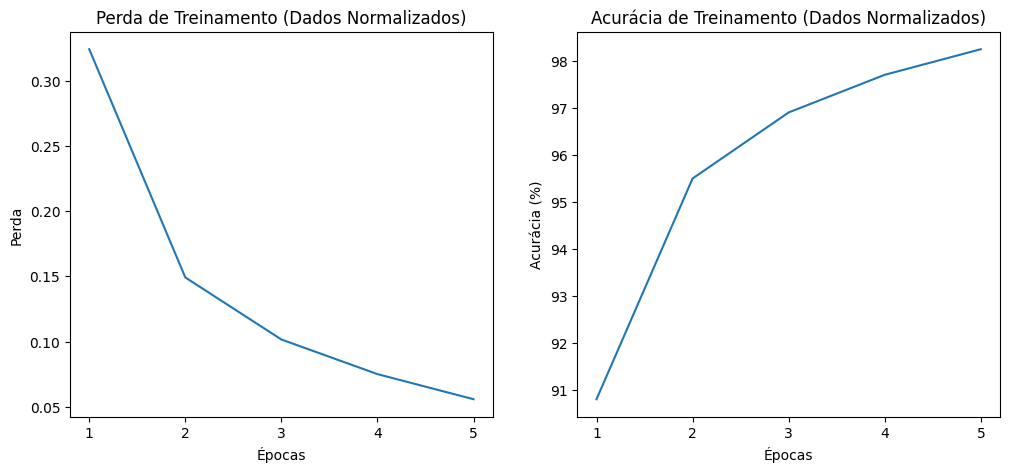

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Gráfico de Perda
ax1.set_xticks([0,1,2,3,4],[1,2,3,4,5])
ax1.plot(history_norm['loss'])
ax1.set_title('Perda de Treinamento (Dados Normalizados)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Perda')

# Gráfico de Acurácia
ax2.set_xticks([0,1,2,3,4],[1,2,3,4,5])
ax2.plot(history_norm['accuracy'])
ax2.set_title('Acurácia de Treinamento (Dados Normalizados)')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia (%)')

plt.show()


In [41]:
mod.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # --- 3. MOVER OS DADOS DE TESTE PARA A GPU --- ### GPU ###
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = mod(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Para a matriz de confusão, precisamos trazer os dados de volta para a CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy_test = 100 * correct / total
print(f'\nAcurácia do modelo no conjunto de teste: {accuracy_test:.2f} %')



Acurácia do modelo no conjunto de teste: 97.45 %


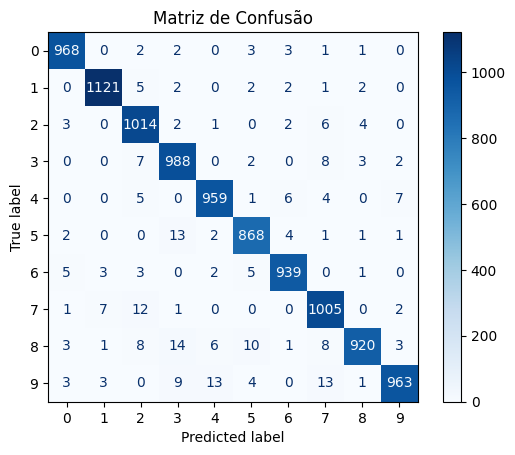

In [42]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## Análise de Desempenho e Generalização do Modelo

A análise do modelo indica um processo de aprendizado eficaz que resultou em uma excelente capacidade de generalização, conforme demonstrado pelo seu forte desempenho no conjunto de teste.

Durante o treinamento, observou-se uma melhoria contínua e estável das métricas no conjunto de treino, indicando que o modelo foi capaz de aprender consistentemente os padrões dos dados fornecidos. O principal indicativo de que este aprendizado não levou a um overfitting prejudicial vem da alta acurácia alcançada no conjunto de teste ao final do processo.

Se o modelo tivesse superajustado significativamente, ele teria essencialmente "decorado" os exemplos de treino, resultando em um baixo desempenho ao ser exposto a dados novos e nunca vistos. O fato de ter alcançado uma alta acurácia no teste contradiz diretamente essa possibilidade.

Embora a ausência de um conjunto de validação durante o treinamento impeça a análise da evolução da generalização a cada época, o resultado final robusto sugere que o número total de épocas foi apropriado, levando a um modelo que não apenas aprendeu bem, mas que também soube generalizar esse conhecimento de forma eficaz.

## Treinamento sem dados normalizados

In [54]:
#Carregamento do dado sem processamento
transform_nonorm = Compose([
    PILToTensor(),
    lambda x: x.float()
])

data_train = datasets.MNIST(root='DataSets', 
                            train=True,
                            download=True,
                            transform= transform_nonorm) 
data_test = datasets.MNIST(root='DataSets', 
                            train=False,
                            download=True,
                            transform= transform_nonorm)
train_loader = dataloader.DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dataloader.DataLoader(dataset=data_test, batch_size=BATCH_SIZE, shuffle=False)


In [55]:
mod = MLP(28*28, 256, 10)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=mod.parameters(), lr=0.001)

print("Arquitetura do Modelo:")
print(mod)

Arquitetura do Modelo:
MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (tanh1): Tanh()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (tanh2): Tanh()
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [56]:
history_norm = {'loss': [], 'accuracy': []}
total_step = len(train_loader)

print("\n--- INICIANDO TREINAMENTO COM DADOS NORMALIZADOS ---")
mod.to(device)
mod.train()
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)
        outputs = mod(images)
        loss = loss_func(outputs, labels)

        # Backward and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Monitoramento
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / total_step
    epoch_acc = 100 * correct / total
    history_norm['loss'].append(epoch_loss)
    history_norm['accuracy'].append(epoch_acc)

    print(f'Época [{epoch+1}/{epochs}], Perda: {epoch_loss:.4f}, Acurácia: {epoch_acc:.2f}%')

print("--- TREINAMENTO CONCLUÍDO ---")


--- INICIANDO TREINAMENTO COM DADOS NORMALIZADOS ---
Época [1/5], Perda: 0.4285, Acurácia: 87.33%
Época [2/5], Perda: 0.3385, Acurácia: 89.30%
Época [3/5], Perda: 0.2847, Acurácia: 91.22%
Época [4/5], Perda: 0.2696, Acurácia: 91.65%
Época [5/5], Perda: 0.2485, Acurácia: 92.19%
--- TREINAMENTO CONCLUÍDO ---
